# 1. Imports + Mounting Drive

In [ ]:
#TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model


#Sklearn
from sklearn.preprocessing import normalize

#Colab + Mounting Drive
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

#Utilities
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from pathlib import Path
from PIL import Image

Mounted at /content/drive


# 2. Loading the Inception Network 

In [ ]:
network = InceptionV3(include_top=False, weights='imagenet', pooling='avg')
network.summary()

In [ ]:
#Exploring the network
num_layers = len(network.layers)
num_layers

312

In [ ]:
x = tf.keras.layers.Flatten()(network.output)
model = Model(inputs=network.input, outputs=x)

network.output_shape, model.output_shape


((None, 2048), (None, 2048))

# 3. Preparing the Datasets

In [ ]:
#Getting the Bird Images
! gdown --id 1SbHWZBmgEj6PIPthx8wU6ZHPl-nWPG4Z
! mkdir -p data && unzip -q -d data 100-bird-species.zip
! rm 100-bird-species.zip

#Getting the Distractor
! gdown --id 1-CRBzlwToF2YkiZ9C3Vz6nIvR_AmcS8N
! unzip -q DistractormY2pWptmp
! rm DistractormY2pWptmp

#Downloading the test, valid and train csv files into a dataframe
! gdown --id 1hOwriTnQGvdXD4oEia6LSToQb9PWRKc_
! gdown --id 15kBuMF6J61gGSSVk-qroPlQrCKdHQ-Fw
! gdown --id 10lDa-armyrXooo_kpaal6lQpWfrTC4mZ

#Getting the distractor metadata
!gdown --id 1Gql6qYj9gxUeFnQ2EY1sTG1gaVnsvMxl

train = pd.read_csv('training_set.csv')
test = pd.read_csv('test_set.csv')
valid = pd.read_csv('valid_set.csv')
distractor = pd.read_csv('distractor.csv')  

#Remove the files from runtime
! rm training_set.csv
! rm valid_set.csv
! rm test_set.csv
! rm distractor.csv 

Downloading...
From: https://drive.google.com/uc?id=1SbHWZBmgEj6PIPthx8wU6ZHPl-nWPG4Z
To: /content/100-bird-species.zip
100% 1.25G/1.25G [00:07<00:00, 158MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-CRBzlwToF2YkiZ9C3Vz6nIvR_AmcS8N
To: /content/DistractormY2pWptmp
100% 3.08G/3.08G [01:09<00:00, 44.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hOwriTnQGvdXD4oEia6LSToQb9PWRKc_
To: /content/training_set.csv
100% 2.24M/2.24M [00:00<00:00, 19.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=15kBuMF6J61gGSSVk-qroPlQrCKdHQ-Fw
To: /content/valid_set.csv
100% 280k/280k [00:00<00:00, 4.34MB/s]
Downloading...
From: https://drive.google.com/uc?id=10lDa-armyrXooo_kpaal6lQpWfrTC4mZ
To: /content/test_set.csv
100% 280k/280k [00:00<00:00, 4.31MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Gql6qYj9gxUeFnQ2EY1sTG1gaVnsvMxl
To: /content/distractor.csv
100% 864k/864k [00:00<00:00, 13.7MB/s]


In [ ]:
#show datasets
train, test, valid, distractor

(                                      filepaths                 labels data set
 0               data/train/MALLARD DUCK/119.jpg           MALLARD DUCK    train
 1          data/train/COCK OF THE  ROCK/050.jpg      COCK OF THE  ROCK    train
 2                    data/train/FRIGATE/029.jpg                FRIGATE    train
 3          data/train/AMERICAN REDSTART/056.jpg      AMERICAN REDSTART    train
 4            data/train/POMARINE JAEGER/110.jpg        POMARINE JAEGER    train
 ...                                         ...                    ...      ...
 40460   data/train/CURL CRESTED ARACURI/043.jpg   CURL CRESTED ARACURI    train
 40461       data/train/TURQUOISE MOTMOT/063.jpg       TURQUOISE MOTMOT    train
 40462  data/train/RED BEARDED BEE EATER/002.jpg  RED BEARDED BEE EATER    train
 40463    data/train/WHITE TAILED TROPIC/128.jpg    WHITE TAILED TROPIC    train
 40464      data/train/BAR-TAILED GODWIT/009.jpg      BAR-TAILED GODWIT    train
 
 [40465 rows x 3 columns],

In [ ]:
#This cell is run once to build training/valid/test sets which will be saved and loaded statically afterwards,
#in order to have always the same splits to work with

#Build training and test sets
#target_column = "labels"

#annot = train.append(test).append(valid).reset_index(drop=True)
#annot[target_column] = annot[target_column].astype('category')
#train[target_column] = train[target_column].astype('category')
#valid[target_column] = valid[target_column].astype('category')
#test[target_column] = test[target_column].astype('category')

#from sklearn.model_selection import train_test_split

# 80/10/10 train/val/test split
#train, valtest = train_test_split(annot, test_size=0.2, random_state=42, shuffle=True, stratify=annot[target_column])
#valid, test = train_test_split(valtest, test_size=0.5, shuffle=True, stratify=valtest[target_column])


(40465, 5058, 5059)

In [ ]:
target_column = "labels"

annot = train.append(test).reset_index(drop=True)
annot = annot.append(valid).reset_index(drop=True)
annot[target_column] = annot[target_column].astype('category')

train = annot[:40465].reset_index(drop=True)
test = annot[40465:45524].reset_index(drop=True)
valid = annot[45524:].reset_index(drop=True)

distractor['labels'] = ['distractor']*len(distractor['filepaths'])
distractor[target_column] = distractor[target_column].astype('category')


train, test, valid, distractor, len(train), len(test), len(valid), len(distractor)

(                                      filepaths                 labels data set
 0               data/train/MALLARD DUCK/119.jpg           MALLARD DUCK    train
 1          data/train/COCK OF THE  ROCK/050.jpg      COCK OF THE  ROCK    train
 2                    data/train/FRIGATE/029.jpg                FRIGATE    train
 3          data/train/AMERICAN REDSTART/056.jpg      AMERICAN REDSTART    train
 4            data/train/POMARINE JAEGER/110.jpg        POMARINE JAEGER    train
 ...                                         ...                    ...      ...
 40460   data/train/CURL CRESTED ARACURI/043.jpg   CURL CRESTED ARACURI    train
 40461       data/train/TURQUOISE MOTMOT/063.jpg       TURQUOISE MOTMOT    train
 40462  data/train/RED BEARDED BEE EATER/002.jpg  RED BEARDED BEE EATER    train
 40463    data/train/WHITE TAILED TROPIC/128.jpg    WHITE TAILED TROPIC    train
 40464      data/train/BAR-TAILED GODWIT/009.jpg      BAR-TAILED GODWIT    train
 
 [40465 rows x 3 columns],

In [ ]:
#To avoid calling train test split to have unique training set across all runs
#train.to_csv('/content/drive/MyDrive/MIRCVProject/Datasets_metadata/train_test_split/training_set.csv', index=False)
#valid.to_csv('/content/drive/MyDrive/MIRCVProject/Datasets_metadata/train_test_split/valid_set.csv', index=False)
#test.to_csv('/content/drive/MyDrive/MIRCVProject/Datasets_metadata/train_test_split/test_set.csv', index=False)

In [ ]:
from sklearn import preprocessing

def load_image_tf(path, width):
  """ Load an image from a given path and resizes it
  Args:
      - path (str): the path of the image to load
      - width (int): the width and height used for resizing
  Returns:
      - image (PIL.image): the loaded resized image
  """
  image_data = tf.io.read_file(path)   # read image file
  image = tf.image.decode_image(image_data, channels=3, expand_animations=False)  # decode image data as RGB (do not load whole animations, i.e., GIFs)
  image = tf.image.resize(image, (width, width)) # resize
  image = tf.keras.applications.inception_v3.preprocess_input(image)
  return image

def build_data_pipeline(annot, width):
  image_paths = annot.filepaths.map(str)  # Path -> str
  labels = annot[target_column].cat.codes  # integer labels of categories
  data = tf.data.Dataset.from_tensor_slices((image_paths, labels))
  data = data.map(
    lambda x, y: (load_image_tf(x, width), y),  # path -> image, keep y unaltered
    num_parallel_calls=tf.data.AUTOTUNE,  # load in parallel
    deterministic=True  # keep the order (we will shuffle afterward if needed)
  )  
  return data

In [ ]:
batch_size = 16
#224x224 sets
train_dataset_224 = build_data_pipeline(train, 224).batch(batch_size)
valid_dataset_224 = build_data_pipeline(valid, 224).batch(batch_size)
test_dataset_224 = build_data_pipeline(test, 224).batch(batch_size)
#299x299 sets
train_dataset_299 = build_data_pipeline(train, 299).batch(batch_size)
valid_dataset_299 = build_data_pipeline(valid, 299).batch(batch_size)
test_dataset_299 = build_data_pipeline(test, 299).batch(batch_size)

distractor_dataset = build_data_pipeline(distractor, 299).batch(batch_size)

# 4. Building and Training the Classifier 

In [ ]:
#Explore number of classes
pretrained_network = InceptionV3(include_top=False, weights='imagenet', input_shape=(299,299,3), pooling='avg')#tf.keras.models.clone_model(network)
number_of_classes = train[target_column].nunique()
number_of_classes

325

In [ ]:
#Build a classifier on top of the pre-trained network, set seed for reproducibility and trainable=False to freeze the layers

tf.keras.utils.set_random_seed(7)
pretrained_network.trainable = False 


data_augmentation = tf.keras.Sequential([L.RandomFlip("horizontal"),
                                         L.RandomRotation(0.1),
                                         L.RandomZoom(0.2),])

model = tf.keras.models.Sequential([
    data_augmentation,
    pretrained_network,
    tf.keras.layers.Dense(1024, activation='relu', name='classifier_hidden1'),
    tf.keras.layers.Dense(512, activation='relu', name='classifier_hidden2'),
    tf.keras.layers.Dense(number_of_classes, activation='softmax')
])

opt = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    name='Adam'
)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
# Checkpoint best model during training in terms of accuracy on the validation set
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath='ckpt_1',
  save_weights_only=True,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True
)

train_dataset_shuffle = train_dataset_299.shuffle(100)  # shuffles data each epoch

# Train the model
history = model.fit(
  train_dataset_shuffle,
  validation_data=valid_dataset_299,
  # TODO - BEGIN
  epochs = 10,  # choose a reasonable number of epochs
  # TODO - END
  callbacks=[checkpoint_callback]
)

Epoch 1/10
2530/2530 [==============================] - 665s 258ms/step - loss: 2.5437 - accuracy: 0.4399 - val_loss: 1.2914 - val_accuracy: 0.6621
Epoch 2/10
2530/2530 [==============================] - 649s 255ms/step - loss: 1.1307 - accuracy: 0.7004 - val_loss: 0.9031 - val_accuracy: 0.7552
Epoch 3/10
2530/2530 [==============================] - 648s 255ms/step - loss: 0.8547 - accuracy: 0.7704 - val_loss: 0.7138 - val_accuracy: 0.8062
Epoch 4/10
2530/2530 [==============================] - 648s 255ms/step - loss: 0.7128 - accuracy: 0.8047 - val_loss: 0.6611 - val_accuracy: 0.8128
Epoch 5/10
2530/2530 [==============================] - 647s 255ms/step - loss: 0.6216 - accuracy: 0.8286 - val_loss: 0.5830 - val_accuracy: 0.8373
Epoch 6/10
2530/2530 [==============================] - 650s 256ms/step - loss: 0.5500 - accuracy: 0.8464 - val_loss: 0.5465 - val_accuracy: 0.8468
Epoch 7/10
2530/2530 [==============================] - 666s 262ms/step - loss: 0.5028 - accuracy: 0.8577 - val_

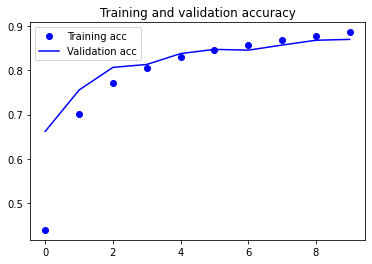

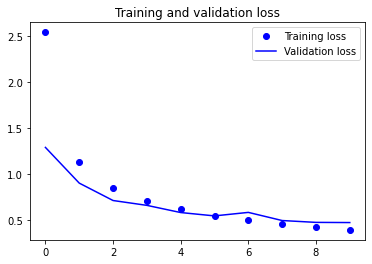

In [ ]:
#Plot results of training for training/validation accuracy and loss
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#Test Classifier

#This is the best classifier so far ---- Use it when you finetune

!gdown --id 1-493-20OgHYBoYN_aReqAytEeNifp6cf
model = tf.keras.models.load_model('inception_classifier_trained_correct_299x299.h5')
test_loss, test_accuracy = model.evaluate(test_dataset_299)
test_accuracy

Downloading...
From: https://drive.google.com/uc?id=1-493-20OgHYBoYN_aReqAytEeNifp6cf
To: /content/inception_classifier_trained_correct_299x299.h5
100% 121M/121M [00:01<00:00, 102MB/s] 
317/317 [==============================] - 54s 166ms/step - loss: 0.4611 - accuracy: 0.8769


0.8768531084060669

In [ ]:
#Save the classifier model to drive
model.save('/content/drive/MyDrive/MIRCVProject/Models/experiments/inception_classifier_trained_correct_299x299.h5')

# 5. Finetuning

In [ ]:
#Redefine optimizer and regulizer for finetuning
opt = tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    name='Adam'
)

regularizer = tf.keras.regularizers.l2(0.001)


model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [ ]:
start_index = 87                #Starting from inception block 3 onwards

layers_to_finetune = model.layers[1].layers[start_index:]

for l in layers_to_finetune:
  is_bn = l.name.startswith('batch_norm')  # keep BatchNorm freezed, good practice for finetuned models
  l.trainable = False if is_bn else True  # or: l.trainable = not is_bnNote that
#Uncomment to add regularization
"""
  for attr in ['kernel_regularizer']:
    if hasattr(l, attr):
      setattr(l, attr, regularizer)
for l in model.layers[2:]:
  for attr in ['kernel_regularizer']:
    if hasattr(l, attr):
      setattr(l, attr, regularizer)
"""

"\n  for attr in ['kernel_regularizer']:\n    if hasattr(l, attr):\n      setattr(l, attr, regularizer)\nfor l in model.layers[2:]:\n  for attr in ['kernel_regularizer']:\n    if hasattr(l, attr):\n      setattr(l, attr, regularizer)\n"

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dense_8 (Dense)             (None, 325)               166725    
                                                                 
Total params: 24,592,485
Trainable params: 23,553,349
Non-trainable params: 1,039,136
_________________________________________________________________


In [ ]:
# Checkpoint best model during training in terms of accuracy on the validation set
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
  filepath='ckpt_2',
  save_weights_only=True,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True
)

train_dataset_shuffle = train_dataset_299.shuffle(100)  # shuffles data each epoch

# Train the model
history = model.fit(
  train_dataset_shuffle,
  validation_data=valid_dataset_299,
  # TODO - BEGIN
  epochs = 10,  # choose a reasonable number of epochs
  # TODO - END
  callbacks=[checkpoint_callback]
)

Epoch 1/10
2530/2530 [==============================] - 491s 191ms/step - loss: 0.3687 - accuracy: 0.8923 - val_loss: 0.4422 - val_accuracy: 0.8743
Epoch 2/10
2530/2530 [==============================] - 485s 191ms/step - loss: 0.3488 - accuracy: 0.8983 - val_loss: 0.4445 - val_accuracy: 0.8784
Epoch 3/10
2530/2530 [==============================] - 483s 190ms/step - loss: 0.3267 - accuracy: 0.9025 - val_loss: 0.4569 - val_accuracy: 0.8780
Epoch 4/10
2530/2530 [==============================] - 517s 203ms/step - loss: 0.3107 - accuracy: 0.9071 - val_loss: 0.4271 - val_accuracy: 0.8855
Epoch 5/10
2530/2530 [==============================] - 484s 190ms/step - loss: 0.2911 - accuracy: 0.9131 - val_loss: 0.4371 - val_accuracy: 0.8774
Epoch 6/10
2530/2530 [==============================] - 517s 203ms/step - loss: 0.2777 - accuracy: 0.9168 - val_loss: 0.3986 - val_accuracy: 0.8926
Epoch 7/10
2530/2530 [==============================] - 486s 191ms/step - loss: 0.2692 - accuracy: 0.9173 - val_

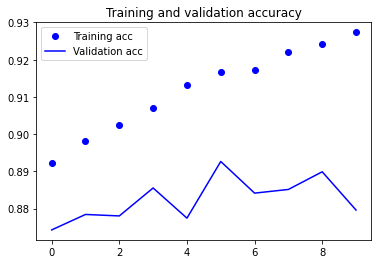

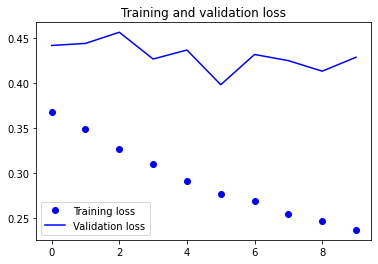

In [ ]:
#Plot results of training for training/validation accuracy and loss
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#Test finetuned model
test_loss, test_accuracy = model.evaluate(test_dataset_299)
test_accuracy

317/317 [==============================] - 51s 161ms/step - loss: 0.4158 - accuracy: 0.8939


0.8938525319099426

In [ ]:
#Saving the finetuned model to drive
model.save('/content/drive/MyDrive/MIRCVProject/Models/experiments/inception_classifier_finetune_block3_87_299x299.h5')


# 6. Testing the Models


**The** following optimizer was used for all the following tests:

    tf.keras.optimizers.Adam(learning_rate=0.0001,name='Adam')

And the following regularizer was used whenever the word regularized is written:
  
    tf.keras.regularizers.l2(0.001)

In [ ]:
#Only Classifier 299x299 (DataAug)
!gdown --id 1-493-20OgHYBoYN_aReqAytEeNifp6cf
model = tf.keras.models.load_model('inception_classifier_trained_correct_299x299.h5')
test_loss, test_accuracy = model.evaluate(test_dataset_299)
test_accuracy

Downloading...
From: https://drive.google.com/uc?id=1-493-20OgHYBoYN_aReqAytEeNifp6cf
To: /content/inception_classifier_trained_correct_299x299.h5
100% 121M/121M [00:02<00:00, 53.3MB/s]
317/317 [==============================] - 63s 161ms/step - loss: 0.4611 - accuracy: 0.8769


0.8768531084060669

In [ ]:
#Only Classifier 224x224 (No data_augment)
!gdown --id 1-1aAIfExKodWLSjYRQUNcZr5KH5ViwNf
model = tf.keras.models.load_model('inception_classifier_trained_correct_noAug.h5')
test_loss, test_accuracy = model.evaluate(test_dataset_224)
test_accuracy

Downloading...
From: https://drive.google.com/uc?id=1-1aAIfExKodWLSjYRQUNcZr5KH5ViwNf
To: /content/inception_classifier_trained_correct_noAug.h5
100% 122M/122M [00:02<00:00, 54.5MB/s]
317/317 [==============================] - 35s 101ms/step - loss: 0.6305 - accuracy: 0.8434


0.8434473276138306

In [ ]:
#Only Classifier 224x224 (DataAug)
!gdown --id 1mkfd8rSfDvoadHbFw8bzrbQUHuks_lye
model = tf.keras.models.load_model('inception_classifier_trained_correct_Aug.h5')
test_loss, test_accuracy = model.evaluate(test_dataset_224)
test_accuracy

Downloading...
From: https://drive.google.com/uc?id=1mkfd8rSfDvoadHbFw8bzrbQUHuks_lye
To: /content/inception_classifier_trained_correct_Aug.h5
100% 121M/121M [00:02<00:00, 55.7MB/s]
317/317 [==============================] - 34s 99ms/step - loss: 0.5444 - accuracy: 0.8450


0.8450286388397217

In [ ]:
#Finetuned from block 3 - 299x299
!gdown --id 1-3HvNNpKdtoDvi3eEQ7VKM7Un3wqj_ve
model = tf.keras.models.load_model('inception_classifier_finetune_block3_87_299x299.h5')
test_loss, test_accuracy = model.evaluate(test_dataset_299)
test_accuracy

Downloading...
From: https://drive.google.com/uc?id=1-3HvNNpKdtoDvi3eEQ7VKM7Un3wqj_ve
To: /content/inception_classifier_finetune_block3_87_299x299.h5
100% 121M/121M [00:02<00:00, 51.1MB/s]
317/317 [==============================] - 52s 160ms/step - loss: 0.4158 - accuracy: 0.8939


0.8938525319099426

In [ ]:
#Finetuned from block 3 - 299x299 - Regularized
!gdown --id 1HGTGjEHXAojz2GxadHWYm6_Drv4VDLO9
model = tf.keras.models.load_model('inception_classifier_finetune_block3_87_299x299_reg.h5')
test_loss, test_accuracy = model.evaluate(test_dataset_299)
test_accuracy

Downloading...
From: https://drive.google.com/uc?id=1HGTGjEHXAojz2GxadHWYm6_Drv4VDLO9
To: /content/inception_classifier_finetune_block3_87_299x299_reg.h5
100% 121M/121M [00:01<00:00, 85.5MB/s]
317/317 [==============================] - 56s 170ms/step - loss: 15.0968 - accuracy: 0.8925


0.8924688696861267

In [ ]:
#Finetuned from block 3 - 224x224 [No DataAug]
!gdown --id 1xD3dDCPfqkKr22zPtWgJYJYlg0go645O
model = tf.keras.models.load_model('inception_classifier_finetune_block3_87.h5')
test_loss, test_accuracy = model.evaluate(test_dataset_224)
test_accuracy

Downloading...
From: https://drive.google.com/uc?id=1xD3dDCPfqkKr22zPtWgJYJYlg0go645O
To: /content/inception_classifier_finetune_block3_87.h5
100% 122M/122M [00:02<00:00, 43.8MB/s]
317/317 [==============================] - 35s 105ms/step - loss: 161.4218 - accuracy: 0.8636


0.8636094331741333

In [ ]:
#Finetuned from block 9 - 299x299
!gdown --id 1D5rlRbrhBc1jEYTmrHlvCLvd0b_eisDd
model = tf.keras.models.load_model('inception_classifier_finetune_block9_0_249_299x299.h5')
test_loss, test_accuracy = model.evaluate(test_dataset_299)
test_accuracy

Downloading...
From: https://drive.google.com/uc?id=1D5rlRbrhBc1jEYTmrHlvCLvd0b_eisDd
To: /content/inception_classifier_finetune_block9_0_249_299x299.h5
100% 121M/121M [00:02<00:00, 53.3MB/s]
317/317 [==============================] - 52s 160ms/step - loss: 0.4178 - accuracy: 0.8942


0.8942478895187378

In [ ]:
#Finetuned from block 9 - 299x299 - Regularized
!gdown --id 1EMdlLZRzYmB0LfK3TKf-PFEJPqjg4gBI
model = tf.keras.models.load_model('inception_classifier_finetune_block9_0_249_299x299_reg.h5')
test_loss, test_accuracy = model.evaluate(test_dataset_299)
test_accuracy

Downloading...
From: https://drive.google.com/uc?id=1OoIGN0UfJgGi9dA2Xqpp0MusPNh0l232
To: /content/inception_classifier_finetune_block9_0_249_299x299_reg.h5
100% 126M/126M [00:01<00:00, 80.2MB/s]
317/317 [==============================] - 53s 161ms/step - loss: 8.8406 - accuracy: 0.9136


0.9136192798614502

In [ ]:
#Finetuned from block 9 - 224x224
!gdown --id 1-2LOR_LJSK0FLUQaxYFgPNx9dmTSPdz5
model = tf.keras.models.load_model('inception_classifier_finetune_block9_0_249.h5')
#test_loss, test_accuracy = model.evaluate(test_dataset_224)
#test_accuracy

Downloading...
From: https://drive.google.com/uc?id=1-2LOR_LJSK0FLUQaxYFgPNx9dmTSPdz5
To: /content/inception_classifier_finetune_block9_0_249.h5
100% 121M/121M [00:01<00:00, 79.9MB/s]


# 7. Extracting Features using Best Finetuned Model

The best finetuned model proved to be the one finetuned from block 9 onward, with regularization and using 299x299x3 images as inputs, so we will use it to extract the features.

In [ ]:
!gdown --id 1EMdlLZRzYmB0LfK3TKf-PFEJPqjg4gBI
model = tf.keras.models.load_model('inception_classifier_finetune_block9_0_249_299x299_reg.h5')
model.summary()
extractor = tf.keras.models.Model(inputs=model.inputs, outputs=model.get_layer('classifier_hidden2').output)

Downloading...
From: https://drive.google.com/uc?id=1EMdlLZRzYmB0LfK3TKf-PFEJPqjg4gBI
To: /content/inception_classifier_finetune_block9_0_249_299x299_reg.h5
100% 210M/210M [00:01<00:00, 119MB/s]
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 classifier_hidden1 (Dense)  (None, 1024)              2098176   
                                                                 
 classifier_hidden2 (Dense)  (None, 512)               524800    
                                                                 
 dense_8 (Dense)             (None, 325)               166725    
                                                         

In [ ]:
def extract_descriptors(filepaths):
  descriptors = []

  for path in tqdm(filepaths):
    image_data = tf.io.read_file(path)   # read image file
    image = tf.image.decode_image(image_data, channels=3, expand_animations=False)  # decode image data as RGB (do not load whole animations, i.e., GIFs)
    image = tf.image.resize(image, (299, 299)) # resize
    
    image = np.array(image)
    image = np.expand_dims(image, axis=0)   # add batch dimension
    image = image.astype(np.float32)

    image = tf.keras.applications.inception_v3.preprocess_input(image)
    image_descriptor = extractor.predict(image)
    image_descriptor = image_descriptor.squeeze()   # tf.Tensor to numpy array
    descriptors.append(image_descriptor)
  
  return descriptors

In [ ]:
#Perform the extraction and save the descriptors on the Drive

train_descriptors = extract_descriptors(train['filepaths'])
np.save("/content/drive/MyDrive/MIRCVProject/Descriptors_FineTuning/Birds/train_descriptors", train_descriptors)

valid_descriptors = extract_descriptors(valid['filepaths'])
np.save("/content/drive/MyDrive/MIRCVProject/Descriptors_FineTuning/Birds/valid_descriptors", valid_descriptors)

test_descriptors = extract_descriptors(test['filepaths'])
np.save("/content/drive/MyDrive/MIRCVProject/Descriptors_FineTuning/Birds/test_descriptors", test_descriptors)

distractor_descriptors = extract_descriptors(distractor['filepaths'])
np.save("/content/drive/MyDrive/MIRCVProject/Descriptors_FineTuning/Distractor/distractor", distractor_descriptors)

  0%|          | 0/40465 [00:00<?, ?it/s]

  0%|          | 0/5058 [00:00<?, ?it/s]

  0%|          | 0/5059 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]